#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [3]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16559, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 16559 (delta 18), reused 29 (delta 13), pack-reused 16522
Receiving objects: 100% (16559/16559), 15.08 MiB | 24.99 MiB/s, done.
Resolving deltas: 100% (11375/11375), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [4]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.1 MB/s eta 0:00:00
Setup complete. Using torch 2.2.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [5]:
import os
import zipfile

# Set up the paths
HOME = os.getcwd()
DATASET_ZIP_PATH = '/content/Mask labeling.zip'
DATASET_UNZIP_PATH = os.path.join(HOME, 'dataset')

In [6]:
# Unzip the dataset
if not os.path.exists(DATASET_UNZIP_PATH):
    os.makedirs(DATASET_UNZIP_PATH)
    with zipfile.ZipFile(DATASET_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(DATASET_UNZIP_PATH)

DATA_YAML_PATH = os.path.join(DATASET_UNZIP_PATH, 'data.yaml')

In [7]:
# define number of classes based on YAML
import yaml
with open(DATA_YAML_PATH, 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [8]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!



In [14]:
DATA_YAML_PATH = os.path.join(DATASET_UNZIP_PATH, 'data.yaml')

# Read the current contents of data.yaml
with open(DATA_YAML_PATH, 'r') as file:
    data_yaml = yaml.safe_load(file)

# Display the original data.yaml content
print(data_yaml)

# Correct the paths if they are not accurate
data_yaml['train'] = os.path.join('dataset', 'train', 'images')
data_yaml['val'] = os.path.join('dataset', 'valid', 'images')

# Write the corrected paths back to data.yaml
with open(DATA_YAML_PATH, 'w') as file:
    yaml.dump(data_yaml, file)

# Verify the change
with open(DATA_YAML_PATH, 'r') as file:
    updated_yaml = yaml.safe_load(file)
print(updated_yaml)


{'names': ['with_mask', 'without_mask'], 'nc': 2, 'roboflow': {'license': 'CC BY 4.0', 'project': 'mask-rvmro', 'url': 'https://universe.roboflow.com/umm-alqura-v2e1c/mask-rvmro/dataset/10', 'version': 10, 'workspace': 'umm-alqura-v2e1c'}, 'test': '../test/images', 'train': 'dataset/train/images', 'val': 'dataset/valid/images'}
{'names': ['with_mask', 'without_mask'], 'nc': 2, 'roboflow': {'license': 'CC BY 4.0', 'project': 'mask-rvmro', 'url': 'https://universe.roboflow.com/umm-alqura-v2e1c/mask-rvmro/dataset/10', 'version': 10, 'workspace': 'umm-alqura-v2e1c'}, 'test': '../test/images', 'train': 'dataset/train/images', 'val': 'dataset/valid/images'}


In [15]:
%cd /content/yolov5/
!python train.py --img 640 --batch 16 --epochs 100 --data {DATA_YAML_PATH} --cfg ./models/yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2024-04-18 06:44:28.454541: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 06:44:28.454595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 06:44:28.456022: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-18 06:44:29.662440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/yolov5s.yaml, data=/content/yolov5/dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=F

# Evaluate Custom YOLOv5 Detector Performance

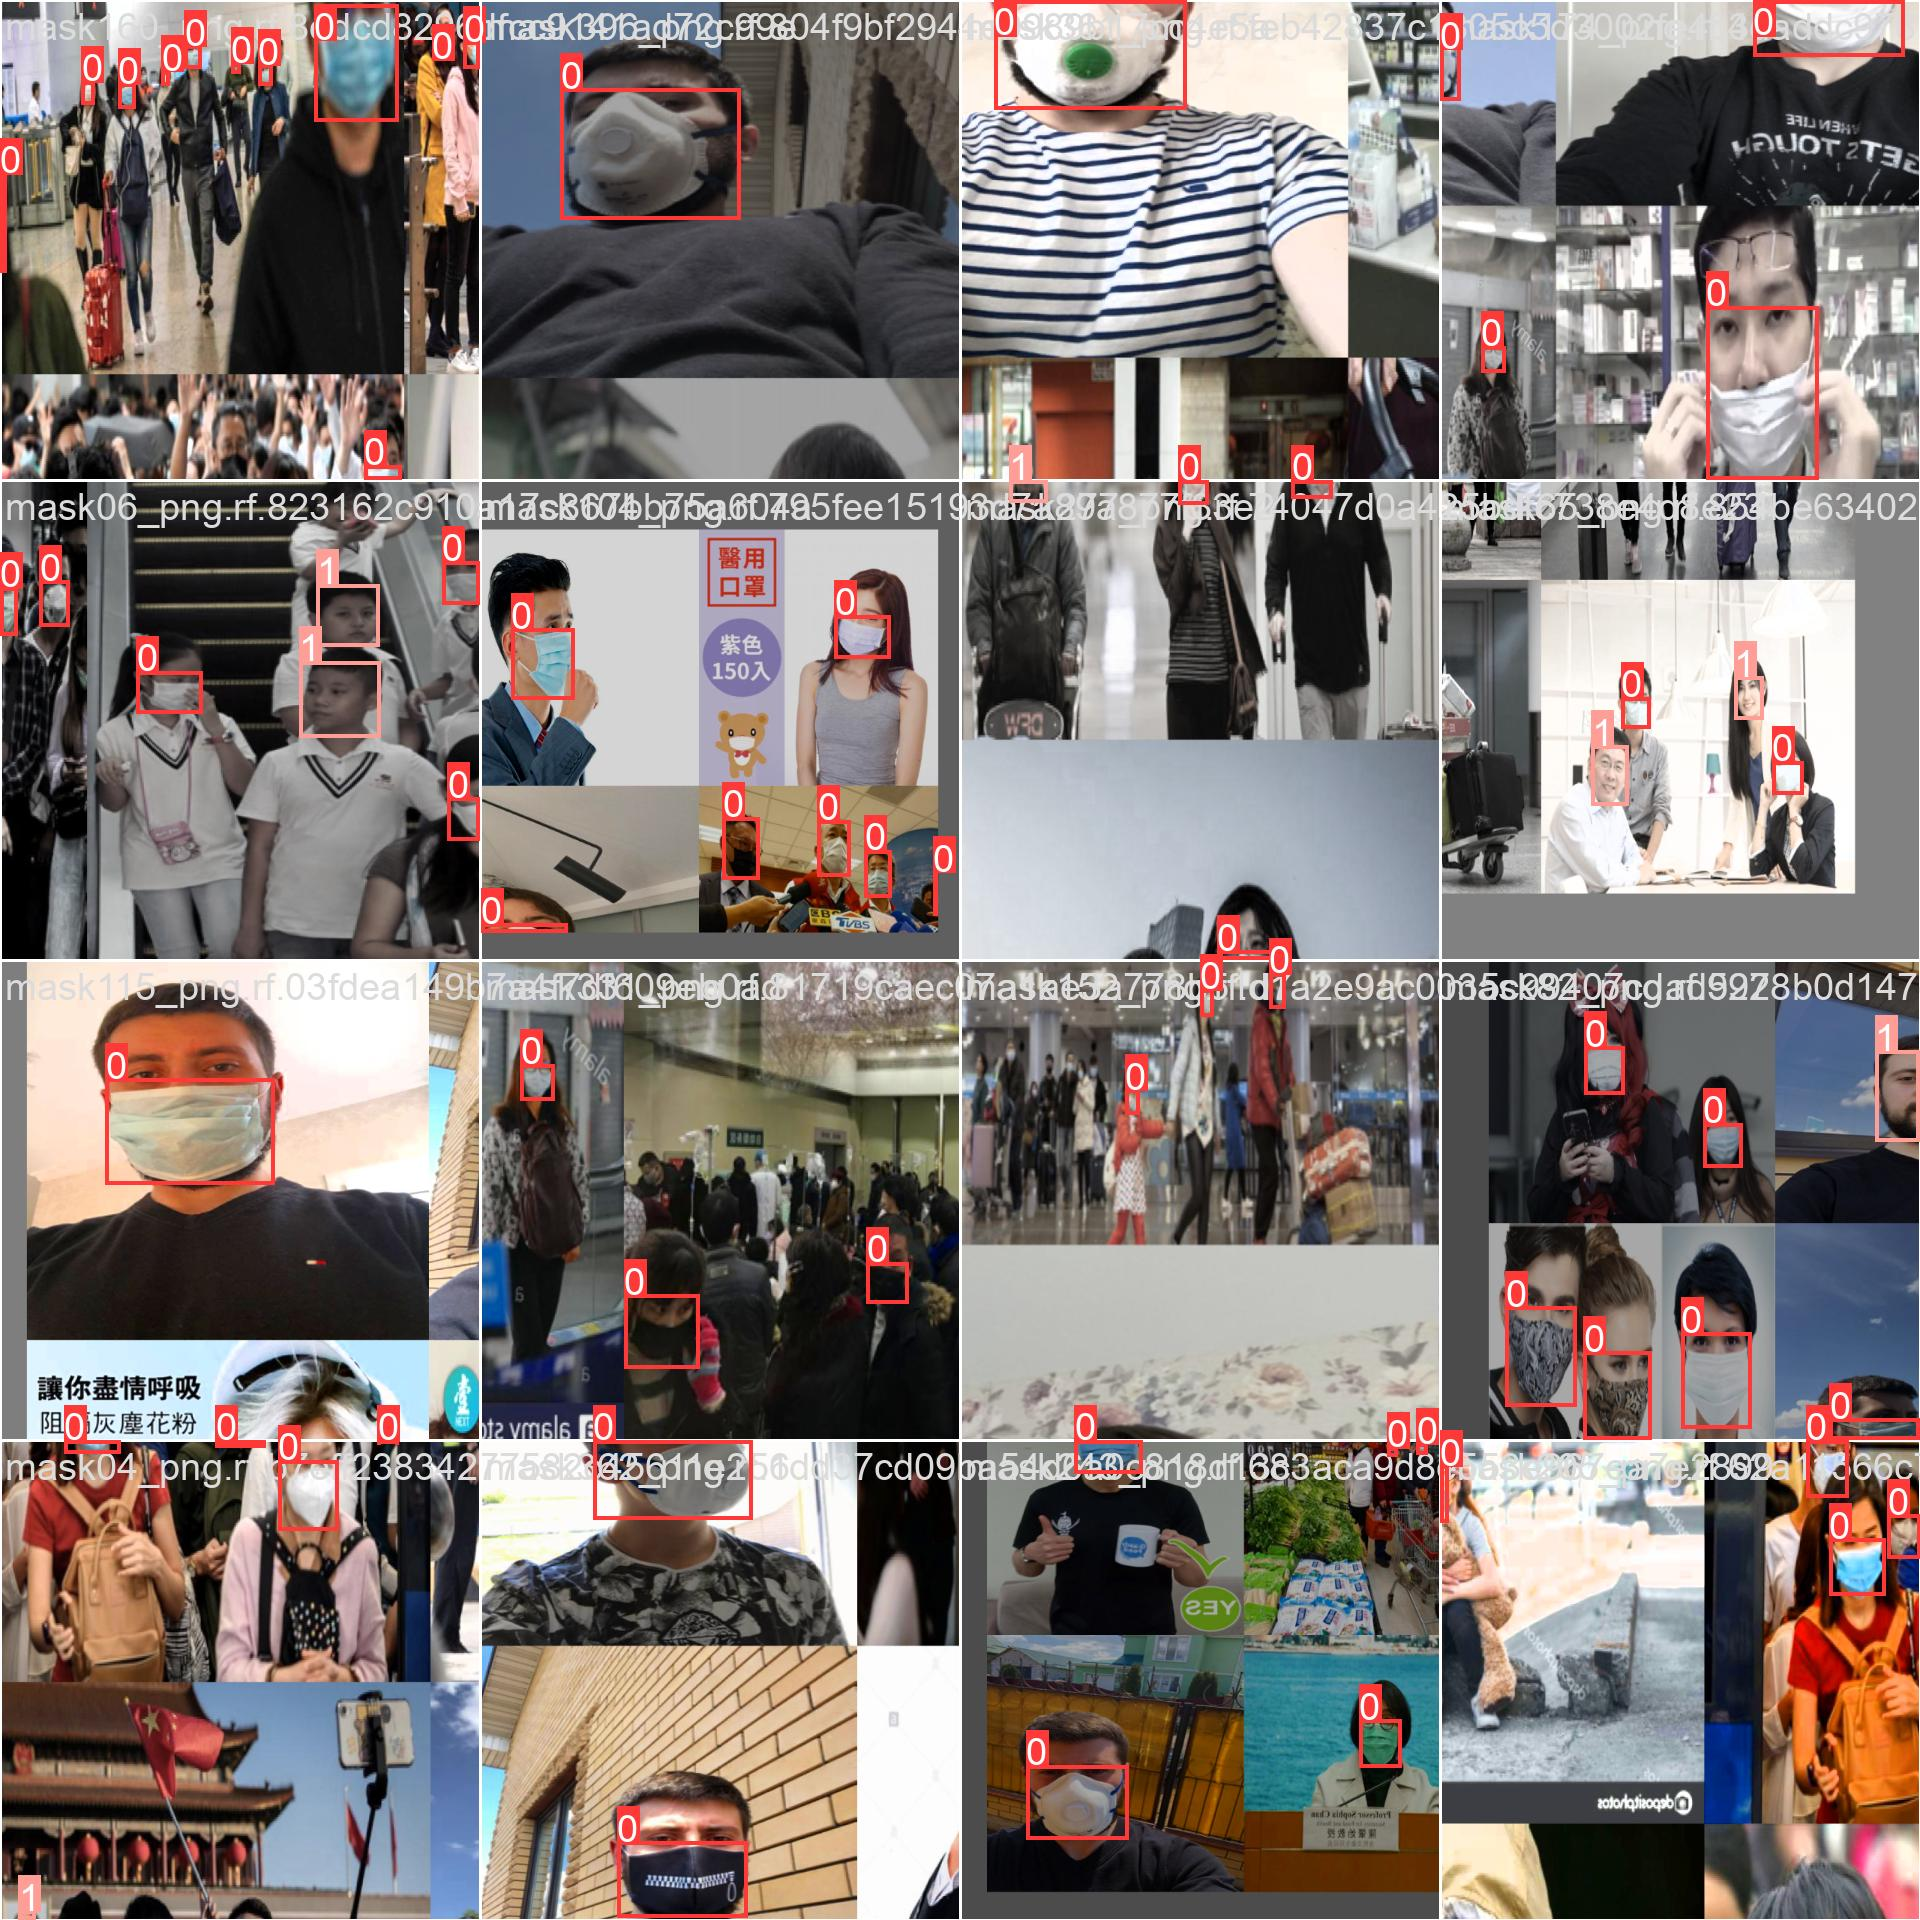

In [17]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results2/train_batch0.jpg', width=1000)  # view results.png

In [ ]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)